#### CSC 180  Intelligent Systems (Fall 2021)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 8: Hyper-parameter Tuning for Backpropagation 


# Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Learning rate
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theata) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $


### The learning rate is an important concept for backpropagation training.  Setting the learning rate can be complex:

* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, or converge to a higher error than a better learning rate.

#### Common values for learning rate are: 0.1, 0.01, 0.001, etc.


# Batch size

#### Number of samples per gradient update.  In keras, you may set the batch_size parameter in function fit()

https://keras.io/models/model/

batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.

# Update rules (optimizers)

The following image shows how each of these algorithms train (image credits: [author](http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms) ):

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")


## An optimizer is one of the two arguments required when you compile a Keras model using compile(). 

Specifying the Update Rule (Optimizer) in Tensorflow

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**

https://keras.io/optimizers/


You can either instantiate an optimizer or you can call it by its name. In the latter case, the default parameters for the optimizer will be used.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=sgd)

#### Using all Default Parameters for a Particular Optimizer

In [8]:
# pass optimizer by name: default parameters will be used
model.compile(loss='mean_squared_error', optimizer='sgd')

## A Complete Example:

Train on 318 samples, validate on 80 samples
Epoch 1/1000
318/318 - 1s - loss: 583.3396 - val_loss: 554.9752
Epoch 2/1000
318/318 - 0s - loss: 581.4490 - val_loss: 553.0596
Epoch 3/1000
318/318 - 0s - loss: 579.5466 - val_loss: 551.1432
Epoch 4/1000
318/318 - 0s - loss: 577.6013 - val_loss: 549.2197
Epoch 5/1000
318/318 - 0s - loss: 575.6504 - val_loss: 547.2726
Epoch 6/1000
318/318 - 0s - loss: 573.6275 - val_loss: 545.3247
Epoch 7/1000
318/318 - 0s - loss: 571.6635 - val_loss: 543.3593
Epoch 8/1000
318/318 - 0s - loss: 569.6459 - val_loss: 541.3770
Epoch 9/1000
318/318 - 0s - loss: 567.6753 - val_loss: 539.3716
Epoch 10/1000
318/318 - 0s - loss: 565.6091 - val_loss: 537.3660
Epoch 11/1000
318/318 - 0s - loss: 563.6237 - val_loss: 535.3466
Epoch 12/1000
318/318 - 0s - loss: 561.5554 - val_loss: 533.3208
Epoch 13/1000
318/318 - 0s - loss: 559.5352 - val_loss: 531.2704
Epoch 14/1000
318/318 - 0s - loss: 557.4393 - val_loss: 529.1824
Epoch 15/1000
318/318 - 0s - loss: 555.3522 - val_loss

Epoch 127/1000
318/318 - 0s - loss: 221.8394 - val_loss: 211.0020
Epoch 128/1000
318/318 - 0s - loss: 218.8784 - val_loss: 208.2583
Epoch 129/1000
318/318 - 0s - loss: 215.9449 - val_loss: 205.5476
Epoch 130/1000
318/318 - 0s - loss: 212.9632 - val_loss: 202.8846
Epoch 131/1000
318/318 - 0s - loss: 210.1351 - val_loss: 200.2228
Epoch 132/1000
318/318 - 0s - loss: 207.2387 - val_loss: 197.5829
Epoch 133/1000
318/318 - 0s - loss: 204.4039 - val_loss: 194.9537
Epoch 134/1000
318/318 - 0s - loss: 201.5977 - val_loss: 192.3352
Epoch 135/1000
318/318 - 0s - loss: 198.7337 - val_loss: 189.7414
Epoch 136/1000
318/318 - 0s - loss: 195.9719 - val_loss: 187.1578
Epoch 137/1000
318/318 - 0s - loss: 193.1836 - val_loss: 184.5990
Epoch 138/1000
318/318 - 0s - loss: 190.3872 - val_loss: 182.0724
Epoch 139/1000
318/318 - 0s - loss: 187.6884 - val_loss: 179.5652
Epoch 140/1000
318/318 - 0s - loss: 184.9422 - val_loss: 177.0889
Epoch 141/1000
318/318 - 0s - loss: 182.3097 - val_loss: 174.6212
Epoch 142/

Epoch 254/1000
318/318 - 0s - loss: 40.5966 - val_loss: 43.9688
Epoch 255/1000
318/318 - 0s - loss: 40.2660 - val_loss: 43.6396
Epoch 256/1000
318/318 - 0s - loss: 39.9283 - val_loss: 43.3193
Epoch 257/1000
318/318 - 0s - loss: 39.6181 - val_loss: 43.0027
Epoch 258/1000
318/318 - 0s - loss: 39.3068 - val_loss: 42.6948
Epoch 259/1000
318/318 - 0s - loss: 39.0079 - val_loss: 42.3932
Epoch 260/1000
318/318 - 0s - loss: 38.7091 - val_loss: 42.0955
Epoch 261/1000
318/318 - 0s - loss: 38.4137 - val_loss: 41.8035
Epoch 262/1000
318/318 - 0s - loss: 38.1350 - val_loss: 41.5163
Epoch 263/1000
318/318 - 0s - loss: 37.8530 - val_loss: 41.2362
Epoch 264/1000
318/318 - 0s - loss: 37.5645 - val_loss: 40.9625
Epoch 265/1000
318/318 - 0s - loss: 37.2919 - val_loss: 40.6914
Epoch 266/1000
318/318 - 0s - loss: 37.0302 - val_loss: 40.4198
Epoch 267/1000
318/318 - 0s - loss: 36.7715 - val_loss: 40.1497
Epoch 268/1000
318/318 - 0s - loss: 36.4961 - val_loss: 39.8843
Epoch 269/1000
318/318 - 0s - loss: 36.2

318/318 - 0s - loss: 19.7179 - val_loss: 20.8392
Epoch 383/1000
318/318 - 0s - loss: 19.6176 - val_loss: 20.7146
Epoch 384/1000
318/318 - 0s - loss: 19.5188 - val_loss: 20.5916
Epoch 385/1000
318/318 - 0s - loss: 19.4249 - val_loss: 20.4682
Epoch 386/1000
318/318 - 0s - loss: 19.3215 - val_loss: 20.3475
Epoch 387/1000
318/318 - 0s - loss: 19.2297 - val_loss: 20.2247
Epoch 388/1000
318/318 - 0s - loss: 19.1313 - val_loss: 20.1032
Epoch 389/1000
318/318 - 0s - loss: 19.0348 - val_loss: 19.9824
Epoch 390/1000
318/318 - 0s - loss: 18.9406 - val_loss: 19.8624
Epoch 391/1000
318/318 - 0s - loss: 18.8441 - val_loss: 19.7438
Epoch 392/1000
318/318 - 0s - loss: 18.7498 - val_loss: 19.6223
Epoch 393/1000
318/318 - 0s - loss: 18.6545 - val_loss: 19.5031
Epoch 394/1000
318/318 - 0s - loss: 18.5634 - val_loss: 19.3841
Epoch 395/1000
318/318 - 0s - loss: 18.4662 - val_loss: 19.2671
Epoch 396/1000
318/318 - 0s - loss: 18.3760 - val_loss: 19.1517
Epoch 397/1000
318/318 - 0s - loss: 18.2823 - val_loss:

Epoch 511/1000
318/318 - 0s - loss: 11.6401 - val_loss: 10.1528
Epoch 512/1000
318/318 - 0s - loss: 11.6077 - val_loss: 10.1085
Epoch 513/1000
318/318 - 0s - loss: 11.5756 - val_loss: 10.0620
Epoch 514/1000
318/318 - 0s - loss: 11.5433 - val_loss: 10.0173
Epoch 515/1000
318/318 - 0s - loss: 11.5118 - val_loss: 9.9715
Epoch 516/1000
318/318 - 0s - loss: 11.4773 - val_loss: 9.9251
Epoch 517/1000
318/318 - 0s - loss: 11.4465 - val_loss: 9.8777
Epoch 518/1000
318/318 - 0s - loss: 11.4145 - val_loss: 9.8319
Epoch 519/1000
318/318 - 0s - loss: 11.3820 - val_loss: 9.7894
Epoch 520/1000
318/318 - 0s - loss: 11.3530 - val_loss: 9.7458
Epoch 521/1000
318/318 - 0s - loss: 11.3207 - val_loss: 9.7028
Epoch 522/1000
318/318 - 0s - loss: 11.2901 - val_loss: 9.6599
Epoch 523/1000
318/318 - 0s - loss: 11.2610 - val_loss: 9.6191
Epoch 524/1000
318/318 - 0s - loss: 11.2299 - val_loss: 9.5794
Epoch 525/1000
318/318 - 0s - loss: 11.2010 - val_loss: 9.5398
Epoch 526/1000
318/318 - 0s - loss: 11.1727 - val_l

Epoch 643/1000
318/318 - 0s - loss: 9.1621 - val_loss: 6.6576
Epoch 644/1000
318/318 - 0s - loss: 9.1533 - val_loss: 6.6438
Epoch 645/1000
318/318 - 0s - loss: 9.1440 - val_loss: 6.6284
Epoch 646/1000
318/318 - 0s - loss: 9.1359 - val_loss: 6.6143
Epoch 647/1000
318/318 - 0s - loss: 9.1275 - val_loss: 6.5998
Epoch 648/1000
318/318 - 0s - loss: 9.1189 - val_loss: 6.5829
Epoch 649/1000
318/318 - 0s - loss: 9.1125 - val_loss: 6.5664
Epoch 650/1000
318/318 - 0s - loss: 9.1029 - val_loss: 6.5550
Epoch 651/1000
318/318 - 0s - loss: 9.0957 - val_loss: 6.5420
Epoch 652/1000
318/318 - 0s - loss: 9.0866 - val_loss: 6.5302
Epoch 653/1000
318/318 - 0s - loss: 9.0788 - val_loss: 6.5193
Epoch 654/1000
318/318 - 0s - loss: 9.0718 - val_loss: 6.5084
Epoch 655/1000
318/318 - 0s - loss: 9.0652 - val_loss: 6.4982
Epoch 656/1000
318/318 - 0s - loss: 9.0562 - val_loss: 6.4907
Epoch 657/1000
318/318 - 0s - loss: 9.0509 - val_loss: 6.4832
Epoch 658/1000
318/318 - 0s - loss: 9.0421 - val_loss: 6.4718
Epoch 65

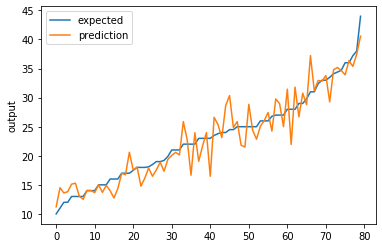

In [2]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

path = "./data/"
preprocess = True

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_numeric_zscore(df, 'year')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
#model.add(Dense(10, activation='tanh'))   
model.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

### Try varying optimizer paramters and batch size after class. 

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)